In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from functions import ReturnsClusteringAnalysis

Plotting Style

In [2]:
plt.style.use('default')
sns.set_palette("husl")

Connect to DB

In [3]:
conn = duckdb.connect('returns.db')

Run once! Build DB from .xlsx

In [ ]:

# conn.execute("INSTALL 'excel'")
# conn.execute("LOAD 'excel'")
# table = 'temp_returns'
# file = 'RETRO_SAMPLE.xlsx'
# conn.execute("CREATE TABLE returns AS SELECT * FROM RETRO_SAMPLE.xlsx")

DuckDB Data

In [ ]:
tables = conn.execute("SHOW TABLES").fetchall()
print(tables)

columns = conn.execute("PRAGMA table_info('returns');").fetchall()
print(columns)

query = conn.execute("""

    SELECT COUNT(DISTINCT CUSTOMER_EMAILID)
    FROM returns
""").fetchone()

print(f"unqiue customer emails: {query}")

cust_orders = conn.execute("""
    SELECT AVG(order_count) AS avg_unique_orders_per_customer
    FROM (
        SELECT CUSTOMER_EMAILID, COUNT(DISTINCT SALES_ORDER_NO) AS order_count
        FROM returns
        GROUP BY CUSTOMER_EMAILID
    );
        """).fetchone()

print(f"average unique orders per customer: {cust_orders}")

cust_returns = conn.execute("""
    SELECT AVG(return_count) AS avg_unique_returns_per_customer
    FROM (
        SELECT CUSTOMER_EMAILID, COUNT(DISTINCT RETURN_NO) AS return_count
        FROM returns
        GROUP BY CUSTOMER_EMAILID
    );
        """).fetchone()

print(f"average unique returns per customer: {cust_returns}")

Load Data

In [4]:

print("loading excel file...")
df = conn.execute("SELECT * FROM returns").df()
print("data loaded successfully.")

loading excel file...
data loaded successfully.


Quick analysis

In [ ]:
print("Dataset shape:", df.shape)
print("\nColumn info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nUnique customer emails:", df['CUSTOMER_EMAILID'].nunique())
print("Average unique orders per customer:", df.groupby('CUSTOMER_EMAILID')['SALES_ORDER_NO'].nunique().mean())
print("Average unique returns per customer:", df.groupby('CUSTOMER_EMAILID')['RETURN_NO'].nunique().mean())


find nulls

In [7]:
print("Missing values:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)
print("\nRETURN_DATE unique values (first 20):")
print(df['RETURN_DATE'].value_counts().head(20))
print("\nRETURN_QTY distribution:")
print(df['RETURN_QTY'].describe())
print("\nRecords with RETURN_QTY > 0:", (df['RETURN_QTY'] > 0).sum())
print("\nUnique customer emails:", df['CUSTOMER_EMAILID'].nunique())
print("Average unique orders per customer:", df.groupby('CUSTOMER_EMAILID')['SALES_ORDER_NO'].nunique().mean())
print("Average unique returns per customer:", df.groupby('CUSTOMER_EMAILID')['RETURN_NO'].nunique().mean())


Missing values:
CUSTOMER_EMAILID       0
SALES_ORDER_NO         0
Q_GMM_ID               0
Q_CLS_ID               0
SKU                    0
Q_SKU_DESC             0
SALES_QTY              0
UNITS_RETURNED_FLAG    0
RETURN_NO              0
RETURN_QTY             0
ORDER_DATE             0
RETURN_DATE            0
dtype: int64

Data types:
CUSTOMER_EMAILID               object
SALES_ORDER_NO                 object
Q_GMM_ID                      float64
Q_CLS_ID                      float64
SKU                            object
Q_SKU_DESC                     object
SALES_QTY                     float64
UNITS_RETURNED_FLAG            object
RETURN_NO                      object
RETURN_QTY                    float64
ORDER_DATE             datetime64[us]
RETURN_DATE                    object
dtype: object

RETURN_DATE unique values (first 20):
RETURN_DATE
-                     777156
44911.583460648151        42
45094.962951388887        39
45741.751030092593        36
45231.81386574074    

Build Class

In [5]:
# Initialize analyzer
print("initializing ReturnsClusteringAnalysis...")
analyzer = ReturnsClusteringAnalysis(df)
print("ReturnsClusteringAnalysis initialized.")


initializing ReturnsClusteringAnalysis...
ReturnsClusteringAnalysis initialized.


Prep Data

In [6]:
customer_features = analyzer.prepare_customer_features()
print(f"\nCustomer features created for {len(customer_features)} customers")
print("\nFeatures overview:")
print(customer_features.describe())

Analyzing data structure...
UNITS_RETURNED_FLAG distribution:
UNITS_RETURNED_FLAG
No     777156
Yes    271409
Name: count, dtype: int64

Records with RETURN_QTY > 0: 271,409
Returns by FLAG='Yes': 271,409
Returns by QTY>0: 271,409
Using UNITS_RETURNED_FLAG = 'Yes' method
Final return records: 271,409 out of 1,048,565 total records
Analyzing 12,709 customers who have made returns
Total records for these customers: 987,786
Sales records: 716,377
Return records: 271,409
Valid return dates: 0
Calculating cross-order return patterns...

Using features for clustering: ['SALES_ORDER_NO_nunique', 'SKU_nunique', 'RETURN_RATE', 'RETURN_RATIO', 'RETURN_FREQUENCY', 'RETURN_PRODUCT_VARIETY', 'CUSTOMER_LIFETIME_DAYS', 'RECENT_ORDERS', 'RECENT_RETURNS', 'SALES_QTY_mean', 'DAYS_TO_FIRST_RETURN', 'RETURN_DATE_SPREAD', 'ORDERS_BEFORE_FIRST_RETURN', 'AVG_RETURNS_PER_BATCH', 'RETURN_VELOCITY']
Customer features created for 12,514 customers

Customer features created for 12514 customers

Features overview:

finding optimal number of clusters...


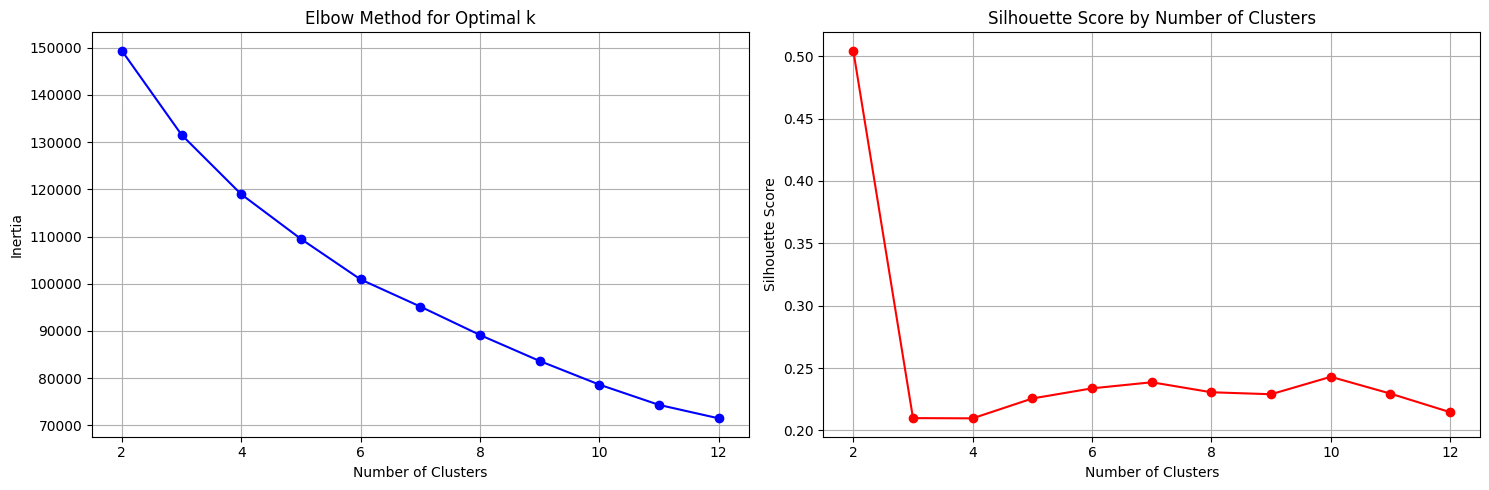

Recommended number of clusters: 2
Silhouette score: 0.504
Optimal number of clusters found: 2
Using different clustesr for testing...


In [8]:
# Find optimal number of clusters
print("finding optimal number of clusters...")
optimal_k, scores = analyzer.find_optimal_clusters(max_clusters=12)
print(f"Optimal number of clusters found: {optimal_k}")
print("Using different clustesr for testing...")


Testing with 5 clusters

In [10]:
print(f"\n=== FINAL CLUSTERING WITH 5 SEGMENTS ===")
cluster_labels, cluster_centers = analyzer.perform_clustering(n_clusters=5)
print("Analyzing cluster characteristics...")
cluster_summary, interpretations = analyzer.analyze_clusters()


=== FINAL CLUSTERING WITH 5 SEGMENTS ===
Features for clustering: ['SALES_ORDER_NO_nunique', 'SKU_nunique', 'RETURN_RATE', 'RETURN_RATIO', 'RETURN_FREQUENCY', 'RETURN_PRODUCT_VARIETY', 'CUSTOMER_LIFETIME_DAYS', 'RECENT_ORDERS', 'RECENT_RETURNS', 'SALES_QTY_mean', 'DAYS_TO_FIRST_RETURN', 'RETURN_DATE_SPREAD', 'ORDERS_BEFORE_FIRST_RETURN', 'AVG_RETURNS_PER_BATCH', 'RETURN_VELOCITY']
Number of features: 15
Using existing scaler parameters
Scaled data shape: (12514, 15)
Cluster centers shape: (5, 15)
Features columns length: 15
Analyzing cluster characteristics...
=== CLUSTER ANALYSIS ===
         AVG_ORDERS  CUSTOMER_COUNT  AVG_RETURN_RATE  AVG_RETURN_RATIO  \
CLUSTER                                                                  
0              6.08             318             3.03              5.24   
1             17.54            2859             0.27              0.18   
2            126.45             369             0.67              0.49   
3             26.98            6454  

KeyError: 'ORDERS_BEFORE_FIRST_RETURN'

In [ ]:
cluster_summary.to_csv('cluster_summary.csv', index=False)

In [ ]:
# Visualize
print("visualizing clusters...")
analyzer.visualize_clusters()
print("Clusters visualized successfully.")


In [ ]:
# Export results
print("exporting results...")
results = analyzer.export_results()
print("Results exported successfully.")


In [ ]:
# High-risk customers (for retention campaigns)
high_risk_clusters = [i for i, info in interpretations.items() 
    if 'HIGH RISK' in info['type'] or 'CHURN RISK' in info['type']]

if high_risk_clusters:
    print(f"High-risk clusters identified: {high_risk_clusters}")
    high_risk_customers = []
    for cluster_id in high_risk_clusters:
        customers = analyzer.get_cluster_customers(cluster_id)
        high_risk_customers.extend(customers)
    
    print(f"Total high-risk customers: {len(high_risk_customers)}")
    
    # Save high-risk customer list
    pd.DataFrame({'CUSTOMER_EMAILID': high_risk_customers}).to_csv('high_risk_customers.csv', index=False)
    print("High-risk customer list saved to 'high_risk_customers.csv'")

# Loyal customers (for rewards programs)
loyal_clusters = [i for i, info in interpretations.items() 
    if 'LOYAL' in info['type']]

if loyal_clusters:
    print(f"\nLoyal clusters identified: {loyal_clusters}")
    loyal_customers = []
    for cluster_id in loyal_clusters:
        customers = analyzer.get_cluster_customers(cluster_id)
        loyal_customers.extend(customers)
    
    print(f"Total loyal customers: {len(loyal_customers)}")
    
    # Save loyal customer list
    pd.DataFrame({'CUSTOMER_EMAILID': loyal_customers}).to_csv('loyal_customers.csv', index=False)
    print("Loyal customer list saved to 'loyal_customers.csv'")
print("\n" + "="*50)
print("MARKETING CAMPAIGN RECOMMENDATIONS")
print("="*50)

for cluster_id, info in interpretations.items():
    customers = analyzer.get_cluster_customers(cluster_id)
    print(f"\n📊 {info['type']}")
    print(f"   👥 Customers: {info['customers']}")
    print(f"   🎯 Action: {info['action']}")
    print(f"   📧 Sample emails: {customers[:3] if len(customers) >= 3 else customers}")

# Cell 12: Additional Analysis (Optional)
# =======================================
# You can add custom analysis here based on your specific business needs

# Example: Analyze return patterns by product category
if 'Q_CLS_ID' in df.columns:
    print("\n" + "="*40)
    print("PRODUCT CATEGORY ANALYSIS")
    print("="*40)
    
    category_returns = df.groupby(['CLUSTER', 'Q_CLS_ID']).agg({
        'RETURN_QTY': 'sum',
        'CUSTOMER_EMAILID': 'nunique'
    }).round(2)
    
    print(category_returns.head(10))

# Example: Time-based analysis
print("\n" + "="*40)
print("SEASONAL RETURN PATTERNS")
print("="*40)

df['ORDER_MONTH'] = pd.to_datetime(df['ORDER_DATE']).dt.month
monthly_returns = df.groupby(['CLUSTER', 'ORDER_MONTH'])['RETURN_QTY'].sum().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(monthly_returns, annot=True, cmap='YlOrRd', fmt='.0f')
plt.title('Return Quantities by Cluster and Month')
plt.xlabel('Month')
plt.ylabel('Cluster')
plt.show()